# SOSE Data
Bottom Temperature and Salinity to compare with ECCOv4r3 and WOA 

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.447ce3e12d994d58b3a30fbae4228f24/status,


In [63]:
client.close()
cluster.close()

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
import geopandas
import scipy
import xesmf as xe
import json

In [2]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "pangeo-tmp/stb2145/models/SOSE/"
    return xr.open_zarr(gcfs_w_token.get_mapper(path + filename), consolidated=False)

coords_unrolled = open_ds('coords.zarr')
ds_tns = open_ds('ds_tns.zarr')

#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
#WG model's boundaries (-77.87497˚S, -57.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #-77.87497
upper_lat = 125 #-57.041634
left_lon =  310 #51.75
right_lon = 880 #146.75

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))
lat_range_u = dict(YG=slice(lower_lat, upper_lat+1))
lon_range_u = dict(XG=slice(left_lon, right_lon+1))

#can't roll_coords=True for this nb
#so instead of load in coords_wg, load in uploaded global coords and then roll/slice
coords = coords_unrolled.roll(XC=700, XG=700).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
coords_surf_mask = coords_unrolled.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, 
                                                                               **lat_range_u, **lon_range_u)
ds = ds_tns.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range)

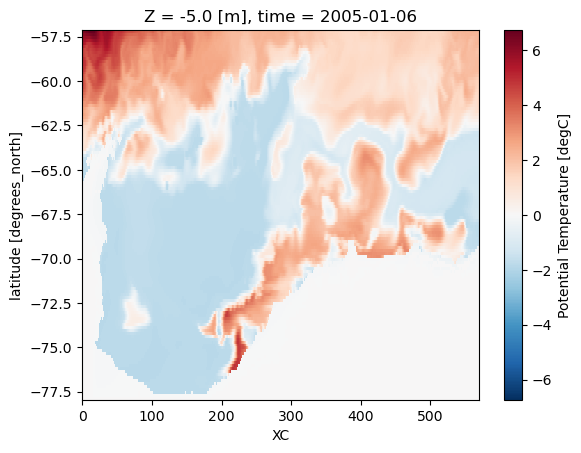

In [3]:
ds.THETA[0,0].drop('XC').plot();

In [4]:
lon_depth = coords.XC
lat_depth = coords.YC

lon_temp = ds.XC
lat_temp = ds.YC

In [5]:
temp_wg = ds.THETA

In [6]:
temp_wg_mean = temp_wg.mean(dim='time')
temp_wg_mean

<xarray.DataArray 'THETA' (Z: 42, YC: 125, XC: 570)>
dask.array<mean_agg-aggregate, shape=(42, 125, 570), dtype=float32, chunksize=(42, 125, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03

In [7]:
#this gives us the depth of the bottom cell
depth_max = ds.Z.where(temp_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [8]:
depth_max.load()

<xarray.DataArray 'Z' (YC: 125, XC: 570)>
array([[-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       ...,
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.]], dtype=float32)
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21

In [9]:
bottom_temp = temp_wg_mean.sel(Z=depth_max.fillna(0.)).load()

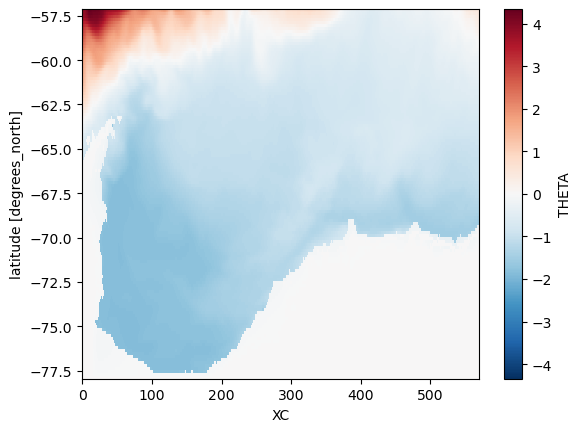

In [71]:
bottom_temp.drop('XC').plot();

In [13]:
np.ravel(bottom_temp).shape

(71250,)

In [14]:
bottom_temp.shape

(125, 570)

In [15]:
125*570

71250

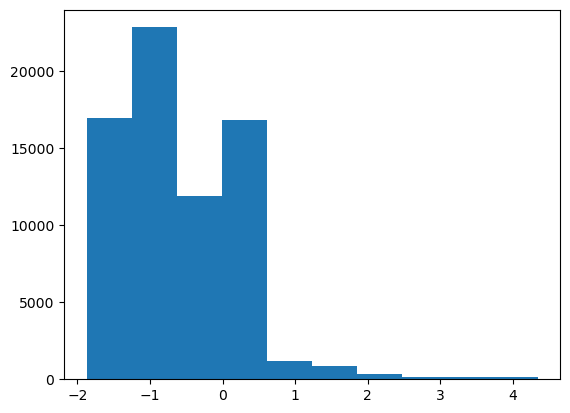

In [16]:
#most of the bottom water is <0 ˚C
plt.hist(np.ravel(bottom_temp));

In [17]:
from scipy.stats import bootstrap
import numpy as np

#convert array to sequence
data = (np.ravel(bottom_temp),)

#calculate 95% bootstrapped confidence interval for median
bootstrap_ci = bootstrap(data, np.mean, confidence_level=0.95,
                         random_state=1, method='percentile')

#view 95% boostrapped confidence interval
print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=-0.6678228706121445, high=-0.6559790074825287)


In [10]:
depth_wg = coords.Depth

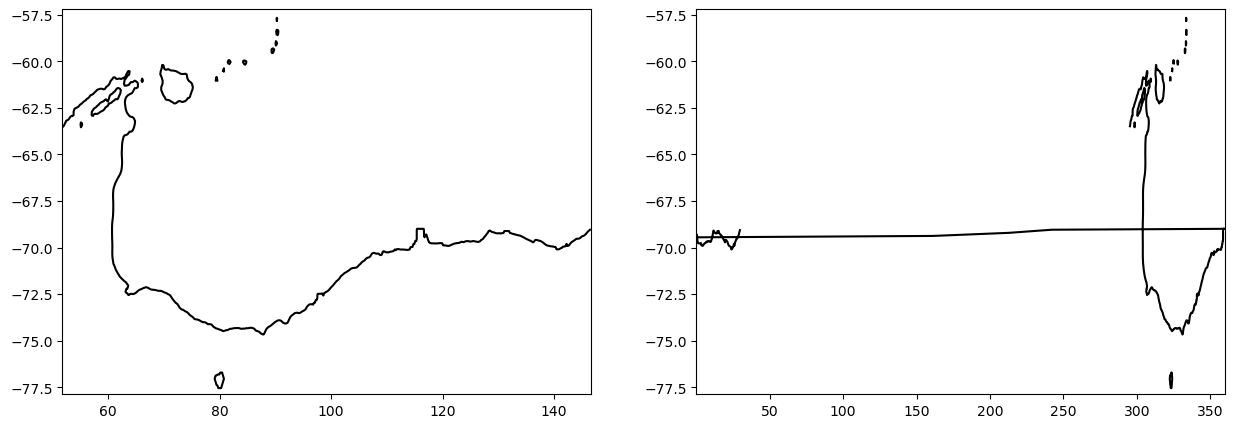

In [19]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(15,5))

ax0.contour(lon_depth, lat_depth, depth_wg, levels=[1000], colors='k')
ax1.contour(lon_temp, lat_temp, coords.Depth, levels=[1000], colors='k')

In [11]:
surface_mask = (coords_surf_mask.hFacC[0] > 0).load()

In [12]:
bottom_temp['lat'] = lat_temp
bottom_temp['lon'] = lon_temp

In [73]:
bottom_temp

<xarray.DataArray 'THETA' (YC: 125, XC: 570)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [3.778035  , 3.7657063 , 3.764736  , ..., 0.36120024, 0.37619293,
        0.38942862],
       [3.8208573 , 3.8038185 , 3.8063753 , ..., 0.4060354 , 0.4132565 ,
        0.42193878],
       [3.8310862 , 3.805684  , 3.806192  , ..., 0.4620544 , 0.4656344 ,
        0.47200996]], dtype=float32)
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
    Z        (YC, XC) float32 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
    lon      (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92

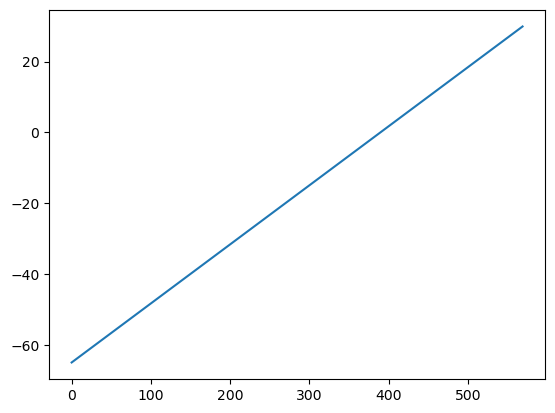

In [13]:
lon_fixed = lon_temp.values
lon_fixed[lon_fixed > 180] -= 360
plt.plot(lon_fixed)

In [25]:
test = xr.DataArray(coords.Depth.values, coords={'YC':lat_temp, 'XC':lon_temp}, name='depth')

In [26]:
test

<xarray.DataArray 'depth' (YC: 125, XC: 570)>
array([[   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [4025.    , 4170.2163, 4333.139 , ..., 5427.3203, 5427.058 ,
        5428.987 ],
       [4275.    , 4275.    , 4304.3105, ..., 5425.079 , 5431.089 ,
        5437.8164],
       [4200.    , 4174.1987, 4147.004 , ..., 5425.623 , 5427.315 ,
        5448.1377]], dtype=float32)
Coordinates:
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92

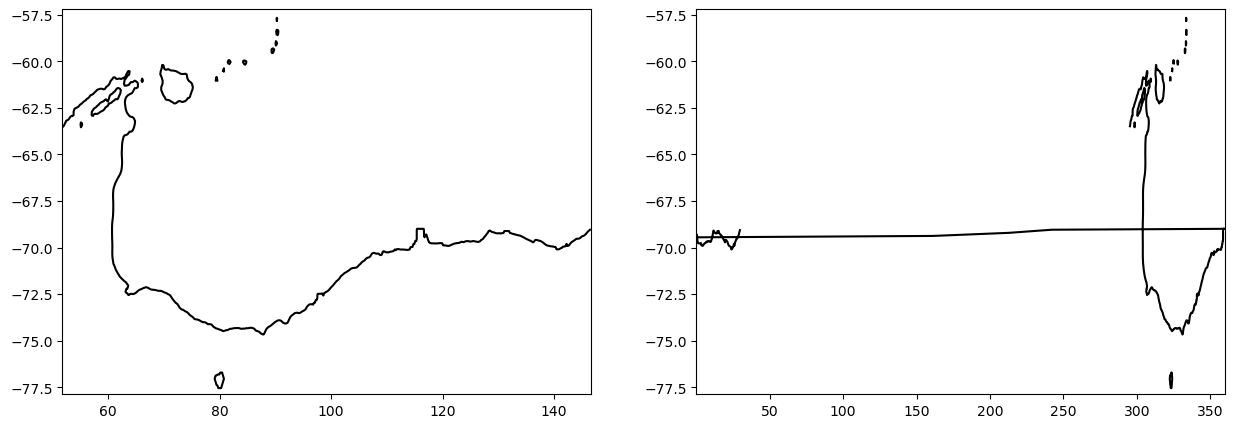

In [28]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(15,5))

ax0.contour(lon_depth, lat_depth, test, levels=[1000], colors='k')
#lon and lat temp didn't have roll_coords=True in definition
ax1.contour(lon_temp, lat_temp, test, levels=[1000], colors='k')

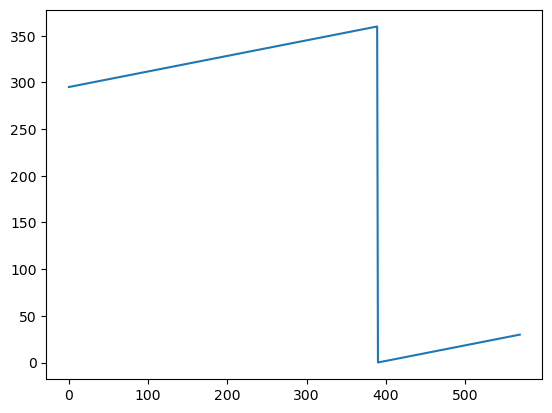

In [29]:
plt.plot(lon_temp.values)

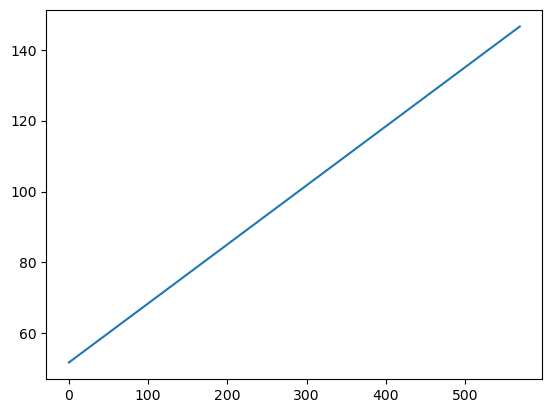

In [30]:
plt.plot(lon_depth.values)

In [14]:
bottom_temp = bottom_temp.assign_coords({'lon': ('XC', lon_fixed)})
bottom_temp

<xarray.DataArray 'THETA' (YC: 125, XC: 570)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [3.778035  , 3.7657063 , 3.764736  , ..., 0.36120024, 0.37619293,
        0.38942862],
       [3.8208573 , 3.8038185 , 3.8063753 , ..., 0.4060354 , 0.4132565 ,
        0.42193878],
       [3.8310862 , 3.805684  , 3.806192  , ..., 0.4620544 , 0.4656344 ,
        0.47200996]], dtype=float32)
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
    Z        (YC, XC) float32 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
    lon      (XC) float32 -64.92 -64.75 -64.58 -64.42 ... 29.58 29.75 29.92

In [15]:
depth = coords.Depth.assign_coords({'lon': ('XC', lon_fixed)}).swap_dims({'XC': 'lon'})
depth

<xarray.DataArray 'Depth' (YC: 125, lon: 570)>
dask.array<getitem, shape=(125, 570), dtype=float32, chunksize=(125, 570), chunktype=numpy.ndarray>
Coordinates:
    XC       (lon) float32 51.75 51.92 52.08 52.25 ... 146.1 146.2 146.4 146.6
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -57.54 -57.37 -57.21
  * lon      (lon) float32 -64.92 -64.75 -64.58 -64.42 ... 29.58 29.75 29.92
Attributes:
    coordinate:     XC YC
    long_name:      ocean depth
    standard_name:  ocean_depth
    units:          m

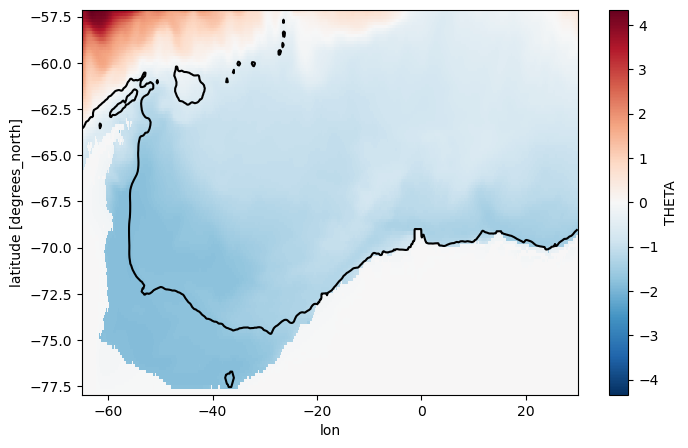

In [33]:
fig, ax = plt.subplots(figsize=(8,5))

ax.contour(lon_fixed, lat_depth, test, levels=[1000], colors='k')
bottom_temp.swap_dims({'XC': 'lon'}).plot(ax=ax)

In [16]:
surf_mask = surface_mask.assign_coords({'lon': ('XC', lon_fixed)})

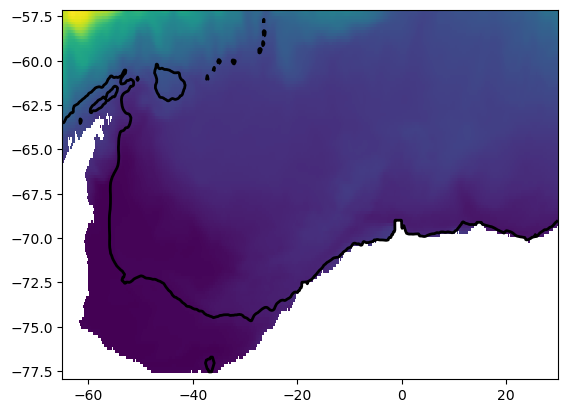

In [38]:
plt.contour(lon_fixed, lat_depth, coords.Depth, levels=[1000], colors='k', linewidths=2)
plt.pcolormesh(lon_fixed, lat_temp, bottom_temp.where(surf_mask))

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


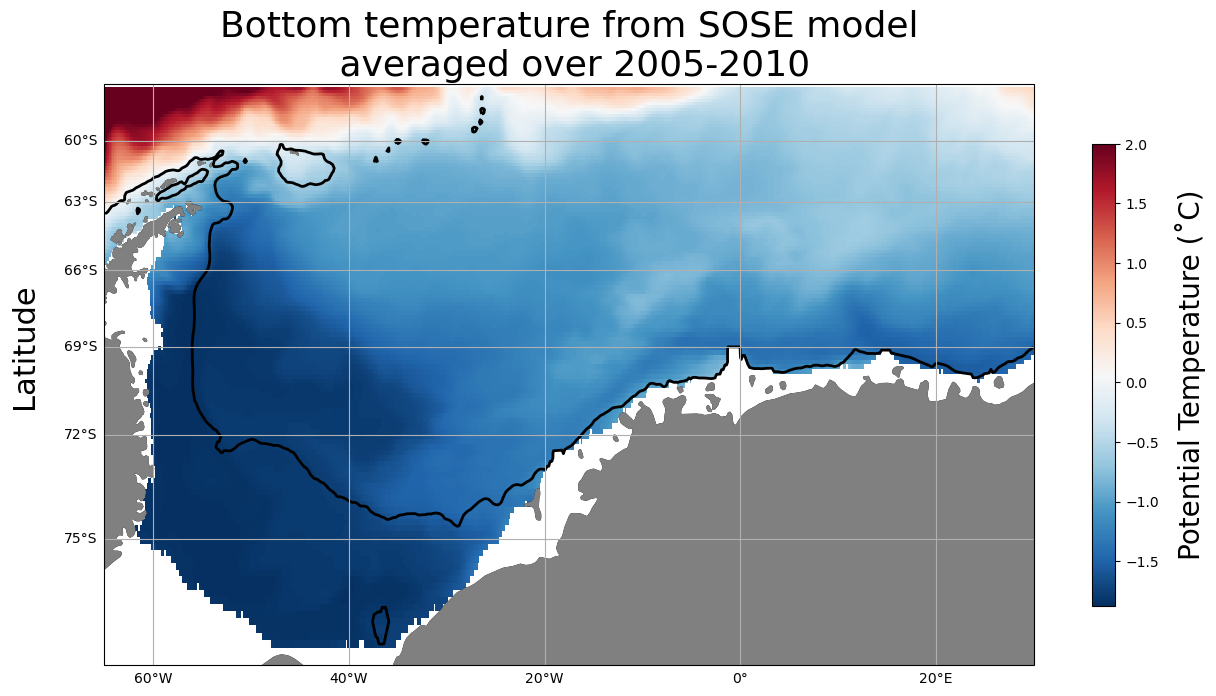

In [17]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon_fixed, lat_depth, coords.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon_fixed, lat_temp, bottom_temp.where(surf_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=22)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from SOSE model\n averaged over 2005-2010', fontsize=26)
plt.savefig('bot-temp-sose-1km-isobath.pdf', transparent=True);

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [40]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.447ce3e12d994d58b3a30fbae4228f24/status,


In [ ]:
std_temp = temp_wg.std('time').load()

In [ ]:
std_temp

In [ ]:
#this gives us the depth of the bottom cell
depth_max_std_temp = ds.Z.where(std_temp.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [ ]:
depth_max_std_temp

In [ ]:
bottom_std_temp = std_temp.sel(Z=depth_max_std_temp.fillna(0.)).load()

In [ ]:
bottom_std_temp = bottom_std_temp.assign_coords({'lon': ('XC', lon_fixed)})

In [ ]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -57], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon_fixed, lat_depth, coords.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon_fixed, lat_temp, bottom_std_temp.where(surf_mask), transform=ccrs.PlateCarree(), 
                   cmap='Blues', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation (˚C)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviation of bottom temperature \n from SOSE model averaged over 2005-2010', fontsize=26)
plt.savefig('std-bot-temp-sose-1km-isobath.pdf', transparent=True);

<span style='color:Green'> **The darker the blue, the more the datapoint is away from mean temperature**

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

## BOTTOM SALT

In [ ]:
slt_wg = ds.SALT

In [ ]:
slt_wg_mean = slt_wg.mean(dim='time')
slt_wg_mean

In [ ]:
#this gives us the depth of the bottom cell
depth_max_slt = ds.Z.where(slt_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [ ]:
bottom_slt = slt_wg_mean.sel(Z=depth_max_slt.fillna(0.)).load()

In [ ]:
bottom_slt = bottom_slt.assign_coords({'lon': ('XC', lon_fixed)})
bottom_slt

In [ ]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(lon_fixed, lat_depth, coords.Depth, levels=[1000], colors='white', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon_fixed, lat_temp, bottom_slt.where(surf_mask), transform=ccrs.PlateCarree(), vmin=34, vmax=35, 
                   cmap='CMRmap')

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity (psu)', labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from SOSE model\n averaged over 2005-2010', fontsize=26 )
plt.savefig('bot-salt-sose-1km-isobath.pdf', transparent=True);

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [55]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.447ce3e12d994d58b3a30fbae4228f24/status,


In [ ]:
std_slt = slt_wg.std('time').load()

In [ ]:
#this gives us the depth of the bottom cell
depth_max_std_slt = ds.Z.where(std_slt.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [ ]:
bottom_std_slt = std_slt.sel(Z=depth_max_std_slt.fillna(0.)).load()

In [ ]:
bottom_std_slt = bottom_std_slt.assign_coords({'lon': ('XC', lon_fixed)})
bottom_std_slt

In [ ]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(lon_fixed, lat_depth, coords.Depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(lon_fixed, lat_temp, bottom_std_slt.where(surf_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=1)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Deviation (psu)', labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation bottom salinity \n from SOSE model averaged over 2005-2010', fontsize=26 )
plt.savefig('std-bot-salt-sose-1km-isobath.pdf', transparent=True);

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)

In [64]:
depth.to_netcdf('depth.nc', mode='w')

In [65]:
surf_mask.to_netcdf('surface_mask.nc', mode='w')

In [66]:
bottom_temp.to_netcdf('bottom_temp.nc', mode='w')

In [67]:
bottom_std_temp.to_netcdf('bottom_std_temp.nc', mode='w')

In [68]:
bottom_slt.to_netcdf('bottom_salt.nc', mode='w')

In [69]:
bottom_std_slt.to_netcdf('bottom_std_salt.nc', mode='w')